In [31]:
# import libraries 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import skfuzzy as fuzz

In [32]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [33]:
# import clean data set

df_wind = pd.read_csv('../../../data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [34]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1


# Partition Clustering

## K-Means

In [35]:
X = df_wind.iloc[:, 2:-1]
X.head()

,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature
0,8.3,296.0,802.0,15.51,-2.0,9.0
1,8.1,298.0,666.0,14.88,-2.0,10.0
2,5.1,297.0,137.0,9.45,-3.0,10.0
3,7.8,301.0,614.0,14.51,-2.0,11.0
4,7.7,301.0,611.0,14.60,-2.0,10.0


since this methods are distance based, we should normalize the values

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns= X_scaled.columns.astype(str)

### Find the optimal k number by the elbow method

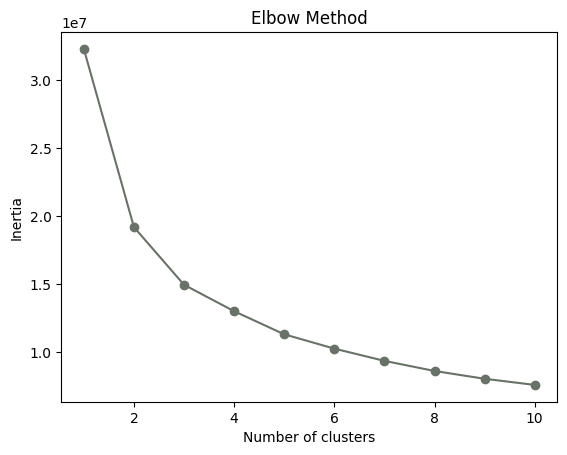

In [37]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 3, because is where inertia starts decreasing in an almost linear rate

### Clusters

In [38]:
X_scaled

,0,1,2,3,4,5
0,0.603829,1.162621,0.268649,1.009130,-2.085222,-1.619341
1,0.536850,1.172544,0.061476,0.838683,-2.085222,-1.488669
2,-0.467835,1.167582,-0.744367,-0.630408,-2.230117,-1.488669
3,0.436382,1.187429,-0.017737,0.738579,-2.085222,-1.357996
4,0.402892,1.187429,-0.022307,0.762929,-2.085222,-1.488669
...,...,...,...,...,...,...
5379905,1.407577,0.805381,2.069975,0.581660,-0.085672,-0.691566
5379906,1.072682,0.805381,1.829105,0.587071,-0.027714,-0.626229
5379907,0.905235,0.805381,1.435141,0.530255,-0.027714,-0.521691
5379908,0.268934,0.805381,0.290022,0.127134,0.015755,-0.508624


In [14]:
# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fit KMeans model again with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(X_scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

In [326]:
df_wind['cluster'] = cluster_labels

In [329]:
most_frequent_clusters = df_wind.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,2
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,2
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,2
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,2
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,2


In [330]:
df_wind.to_csv('results/k_means.csv')

In [292]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,2
1,12,2021-01-01 00:10:00,8.5,314.0,832.0,15.54,-1.0,12.0,1,2
2,13,2021-01-01 00:00:00,8.1,-49.0,749.0,15.23,-2.0,5.0,1,2
3,14,2021-01-01 00:00:00,8.6,-38.0,925.0,15.96,-1.0,15.0,1,2
4,15,2021-01-01 00:00:00,8.8,-47.0,998.0,16.11,-2.0,7.0,1,2


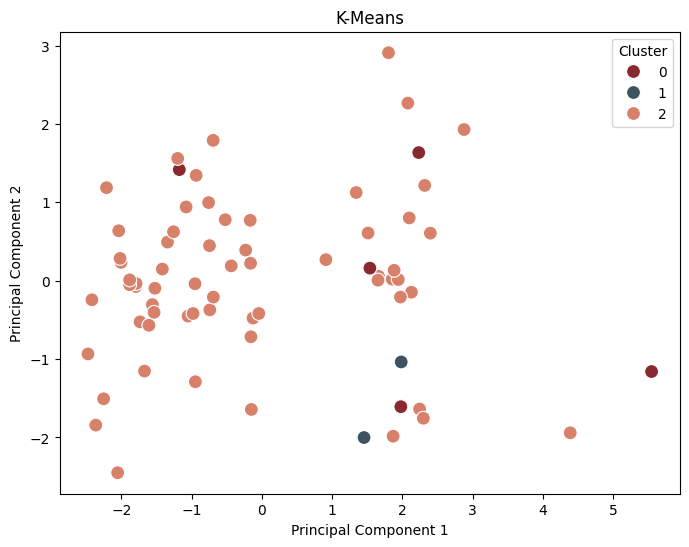

In [293]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster'] = representative_points['cluster']

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=custom_cmap, s=100)
plt.title('K-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

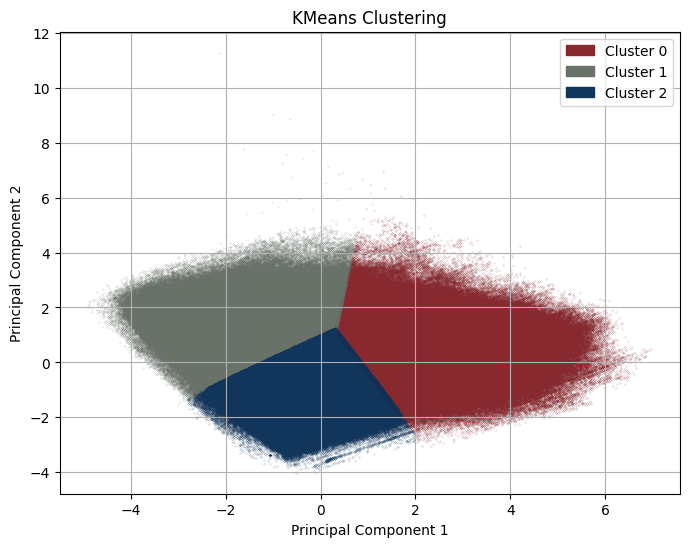

In [294]:
plt.figure(figsize=(8, 6))

# Iterate over unique cluster labels
for i, cluster_label in enumerate(np.unique(cluster_labels)):
    # Filter data points belonging to the current cluster
    cluster_mask = (cluster_labels == cluster_label)
    cluster_data = X_pca[cluster_mask]
    
    # Plot data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=0.01, label=f'Cluster {cluster_label}', color=my_colors[i])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)])
plt.grid(True)
plt.show()


In [262]:
assets_clusters = df_wind.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [17, 28, 29, 110, 115]
Cluster 1: [23, 26]
Cluster 2: [11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 24, 25, 27, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 111, 112, 113, 114, 116, 117, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 510, 511, 512]


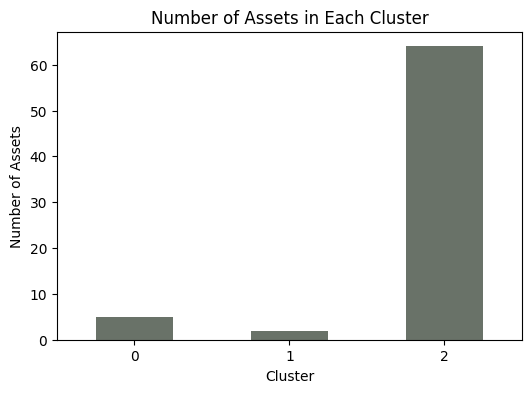

In [263]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[2])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()


In [331]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,2
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,2
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,2
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,2
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,2


In [332]:
df_wind = df_wind.iloc[:,:-1]

## K-Medoids (clara)

In [39]:
def clara(unique_assets, X, num_samples, num_medoids):
    best_cost = float('inf')
    best_labels = None
    for i in range(num_samples):
        sample_indices = np.random.choice(unique_assets, size=num_medoids, replace=False)
        
        # Filter X to include only rows corresponding to selected assets
        X_filtered = pd.DataFrame(X)[pd.DataFrame(X)['asset_id'].isin(sample_indices)]

        # Randomly select one row for each asset
        sample = X_filtered.groupby('asset_id').apply(lambda x: x.sample(1)).reset_index(drop=True)

        kmedoids = KMedoids(n_clusters=3, metric='euclidean', init='k-medoids++', max_iter=300)
        kmedoids.fit(sample)
        if kmedoids.inertia_ < best_cost:
            best_cost = kmedoids.inertia_
            best_labels = kmedoids.labels_
        
        print(f'sample {i} of {num_samples}')
        
    cluster_labels = np.repeat(best_labels, len(df_wind) // len(best_labels) + 1)[:len(df_wind)]

    return cluster_labels

In [40]:
X_scaled['asset_id'] = df_wind['asset_id']
X_scaled

,0,1,2,3,4,5,asset_id
0,0.603829,1.162621,0.268649,1.009130,-2.085222,-1.619341,11
1,0.536850,1.172544,0.061476,0.838683,-2.085222,-1.488669,11
2,-0.467835,1.167582,-0.744367,-0.630408,-2.230117,-1.488669,11
3,0.436382,1.187429,-0.017737,0.738579,-2.085222,-1.357996,11
4,0.402892,1.187429,-0.022307,0.762929,-2.085222,-1.488669,11
...,...,...,...,...,...,...,...
5379905,1.407577,0.805381,2.069975,0.581660,-0.085672,-0.691566,512
5379906,1.072682,0.805381,1.829105,0.587071,-0.027714,-0.626229,512
5379907,0.905235,0.805381,1.435141,0.530255,-0.027714,-0.521691,512
5379908,0.268934,0.805381,0.290022,0.127134,0.015755,-0.508624,512


In [45]:
num_medoids = 71

num_samples = 20

unique_assets = df_wind['asset_id'].unique()

# Run Clara algorithm
cluster_labels_sampled = clara(unique_assets, X_scaled, num_samples, num_medoids)

print(cluster_labels_sampled)

# Add cluster labels to original dataframe
df_wind['cluster'] = cluster_labels_sampled

sample 0 of 20
sample 1 of 20
sample 2 of 20
sample 3 of 20
sample 4 of 20
sample 5 of 20
sample 6 of 20
sample 7 of 20
sample 8 of 20
sample 9 of 20
sample 10 of 20
sample 11 of 20
sample 12 of 20
sample 13 of 20
sample 14 of 20
sample 15 of 20
sample 16 of 20
sample 17 of 20
sample 18 of 20
sample 19 of 20
[0 0 0 ... 2 2 2]


In [335]:
df_wind.to_csv('results/k_medoids_clara.csv', index=False)

In [43]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,Unnamed: 0,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,0,2021-01-01 00:00:00,8.30,296.00,802.00,15.51,-2.00,9.00,1,0
1,12,63135,2021-01-01 00:10:00,8.50,314.00,832.00,15.54,-1.00,12.00,1,0
2,13,137149,2021-01-01 00:00:00,8.10,-49.00,749.00,15.23,-2.00,5.00,1,0
3,14,207980,2021-01-01 00:00:00,8.60,-38.00,925.00,15.96,-1.00,15.00,1,0
4,15,280813,2021-01-01 00:00:00,8.80,-47.00,998.00,16.11,-2.00,7.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
66,414,4949548,2021-01-02 15:00:00,3.70,-362.00,62.00,7.75,7.00,15.00,4,2
67,415,5017640,2021-01-01 00:00:00,4.50,285.00,128.00,9.39,2.00,11.00,4,2
68,510,5090727,2021-01-01 00:00:00,8.45,306.80,1329.78,13.81,1.21,8.06,5,2
69,511,5187755,2021-01-01 00:00:00,8.32,301.15,1310.88,13.66,3.46,10.68,5,2


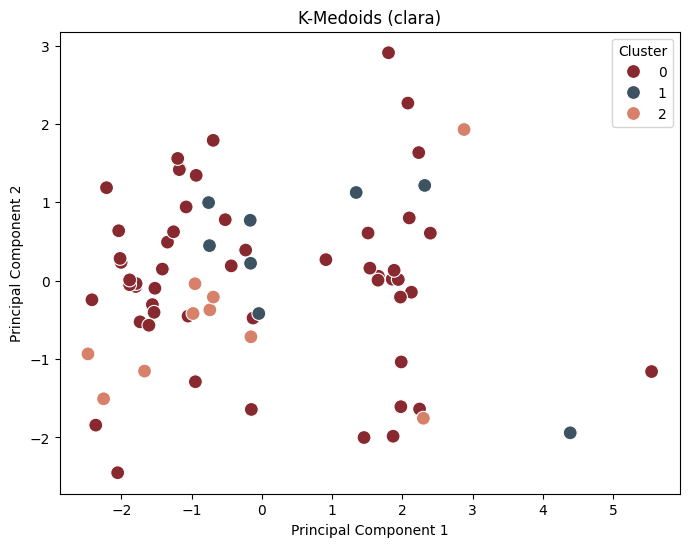

In [12]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster'] = representative_points['cluster']

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=custom_cmap, s=100)
plt.title('K-Medoids (clara)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [51]:
X_scaled = X_scaled.drop(columns='asset_id')

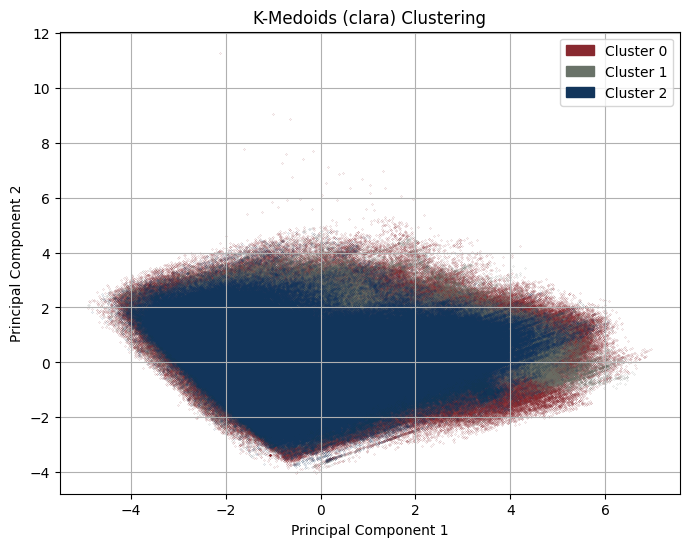

In [52]:
plt.figure(figsize=(8, 6))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Iterate over unique cluster labels
for i, cluster_label in enumerate(np.unique(cluster_labels_sampled)):
    # Filter data points belonging to the current cluster
    cluster_mask = (cluster_labels_sampled == cluster_label)
    cluster_data = X_pca[cluster_mask]
    
    # Plot data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=0.01, label=f'Cluster {cluster_label}', color=my_colors[i])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Medoids (clara) Clustering')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels_sampled)])
plt.grid(True)
plt.show()

In [53]:
assets_clusters = df_wind.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 110, 111, 112, 113, 114, 115, 116, 117]
Cluster 1: [210, 310, 311, 312, 313, 314, 315, 316, 317]
Cluster 2: [410, 411, 412, 413, 414, 415, 510, 511, 512]


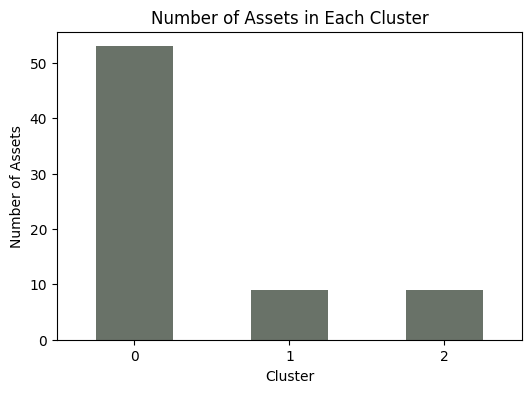

In [54]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Fuzzy C-Means

In [55]:
# Define parameters
num_clusters = 3
fuzziness = 2  # Fuzziness coefficient (m)

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

# Extract cluster centroids
cluster_centroids = cntr.T

# Extract cluster membership probabilities
cluster_membership = u.T

# Assign data points to clusters based on membership probabilities
assigned_clusters = np.argmax(cluster_membership, axis=1)

In [56]:
df_wind['cluster'] = assigned_clusters

In [57]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

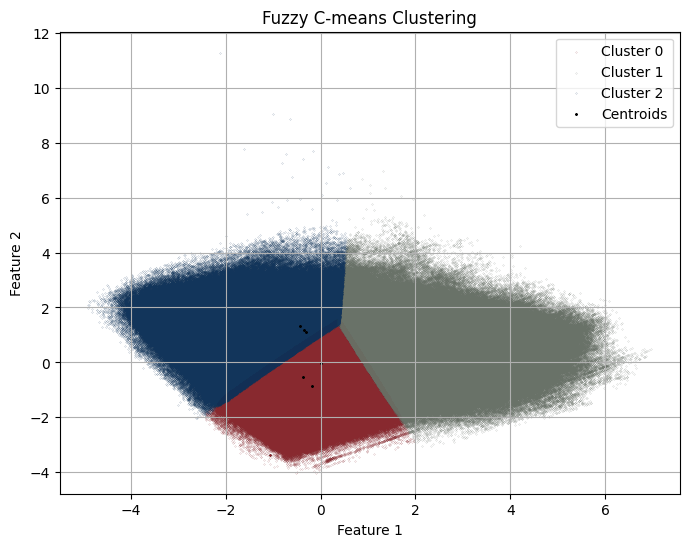

In [58]:
plt.figure(figsize=(8, 6))
for cluster_label, color in zip(range(num_clusters), my_colors):
    cluster_points = X_pca[assigned_clusters == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f'Cluster {cluster_label}', s = 0.01)

# Plot cluster centroids
plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], marker='X', color='black', s=1, label='Centroids')

plt.title('Fuzzy C-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
most_frequent_clusters = df_wind.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

In [60]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_wind.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,Unnamed: 0,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,0,2021-01-01 00:00:00,8.30,296.00,802.00,15.51,-2.00,9.00,1,0
1,12,63135,2021-01-01 00:10:00,8.50,314.00,832.00,15.54,-1.00,12.00,1,0
2,13,137149,2021-01-01 00:00:00,8.10,-49.00,749.00,15.23,-2.00,5.00,1,0
3,14,207980,2021-01-01 00:00:00,8.60,-38.00,925.00,15.96,-1.00,15.00,1,0
4,15,280813,2021-01-01 00:00:00,8.80,-47.00,998.00,16.11,-2.00,7.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
66,414,4949548,2021-01-02 15:00:00,3.70,-362.00,62.00,7.75,7.00,15.00,4,0
67,415,5017640,2021-01-01 00:00:00,4.50,285.00,128.00,9.39,2.00,11.00,4,0
68,510,5090727,2021-01-01 00:00:00,8.45,306.80,1329.78,13.81,1.21,8.06,5,0
69,511,5187755,2021-01-01 00:00:00,8.32,301.15,1310.88,13.66,3.46,10.68,5,2


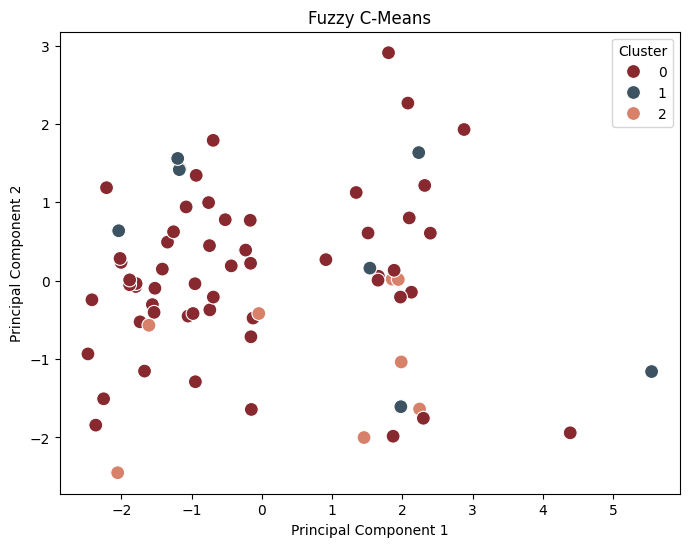

In [61]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster'] = representative_points['cluster']

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=custom_cmap, s=100)
plt.title('Fuzzy C-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [62]:
assets_clusters = df_wind.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 12, 13, 14, 15, 16, 19, 22, 24, 31, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 111, 112, 113, 114, 117, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 510, 512]
Cluster 1: [17, 18, 28, 29, 110, 115, 116]
Cluster 2: [21, 23, 25, 26, 27, 33, 57, 511]


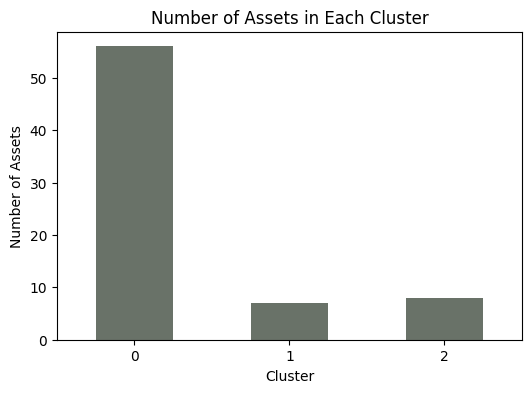

In [63]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()